<a href="https://colab.research.google.com/github/r2nery/lamfo-glove/blob/main/glove_word2vec_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Major source for this notebook](https://www.kaggle.com/code/madz2000/nlp-using-glove-embeddings-99-87-accuracy)

# Loading Dependencies

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import os

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
%cd gdrive/My Drive/LAMFO/lamfo-glove

[Errno 2] No such file or directory: 'gdrive/My Drive/LAMFO/lamfo-glove'
/content/gdrive/My Drive/LAMFO/lamfo-glove


In [43]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Sarcasm Detection

## Loading data

In [44]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

## Data cleaning

In [45]:
df.isna().sum() 

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [46]:
del df['article_link']

In [47]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [48]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

## Basic EDA

### Data balance

In [9]:
df.head()

is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails congress falling short ...
2             0       eat veggies: 9 deliciously different recipes
3             1       inclement weather prevents liar getting work
4             1  mother comes pretty close using word 'streamin...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


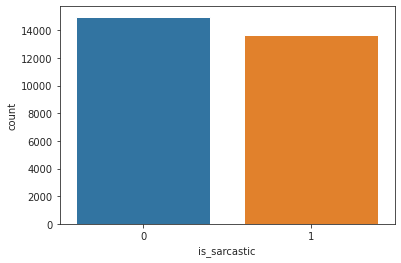

In [10]:
sns.set_style("ticks")
sns.countplot(df.is_sarcastic)
plt.savefig('balance_sarcastic.png', dpi=300)

### Wordcloud: not sarcastic text

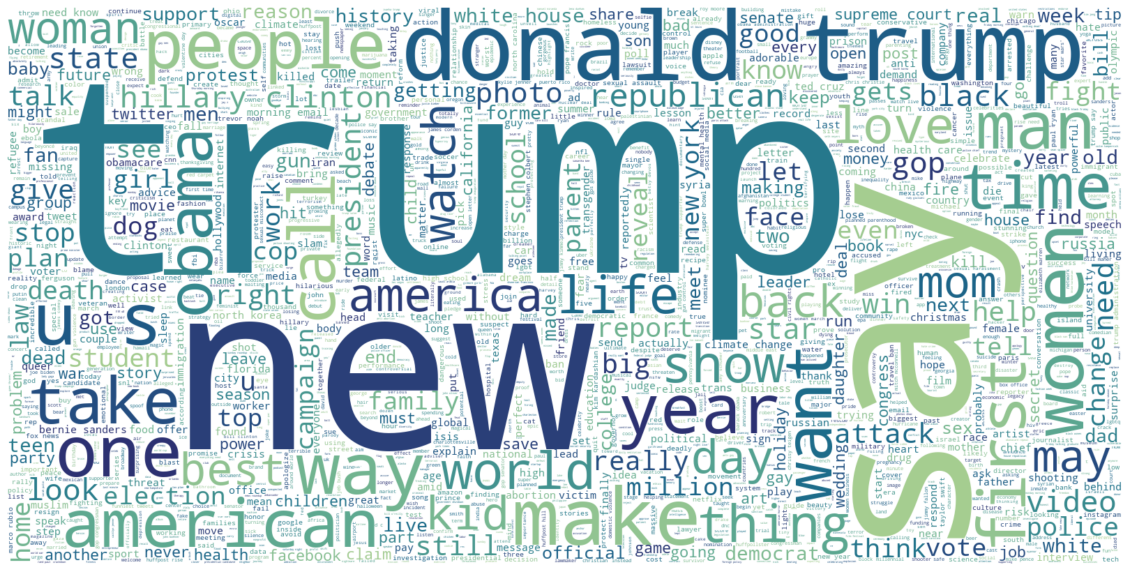

In [11]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white',stopwords = STOPWORDS).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_not_sarcastic.png', dpi=600)

### Wordcloud: sarcastic text

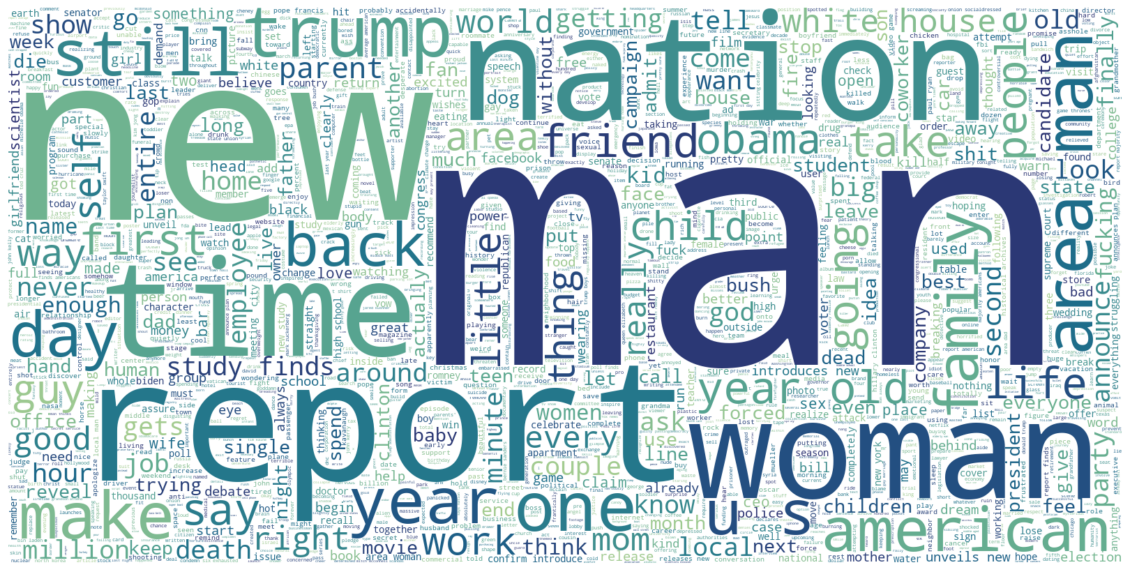

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white',stopwords = STOPWORDS).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_sarcastic.png', dpi=600)

### Number of characters in each text

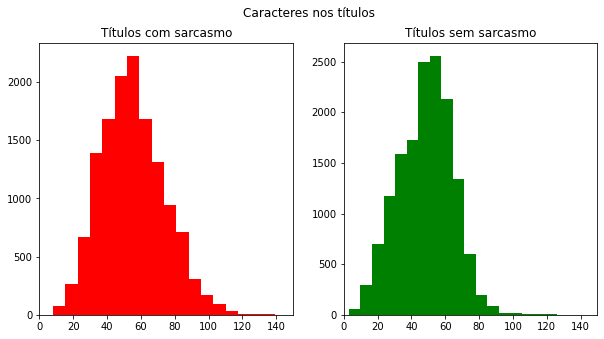

In [51]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red',bins=100)
ax1.set_title('Títulos com sarcasmo')
ax1.set(xlim=(0, 150))
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green',bins=23)
ax2.set_title('Títulos sem sarcasmo')
ax2.set(xlim=(0, 150))
fig.suptitle('Caracteres nos títulos')
plt.savefig('charcount_sarcastic.png', dpi=600)

### Number of words in each text

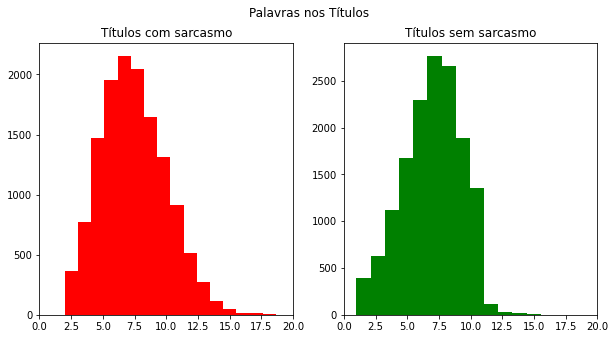

In [50]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',bins=100)
ax1.set_title('Títulos com sarcasmo')
ax1.set(xlim=(0, 20))
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',bins=17)
ax2.set_title('Títulos sem sarcasmo')
ax2.set(xlim=(0, 20))
fig.suptitle('Palavras nos Títulos')
plt.savefig('wordcount_sarcastic.png', dpi=600)

### Average word length in a text

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


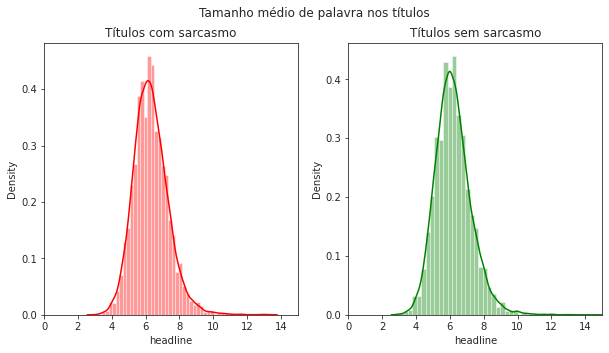

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Títulos com sarcasmo')
ax1.set(xlim=(0, 15))
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Títulos sem sarcasmo')
ax2.set(xlim=(0, 15))
fig.suptitle('Tamanho médio de palavra nos títulos')
plt.savefig('avgwlength_sarcastic.png', dpi=600)

## Word2Vec

### Converting text to format acceptable by gensim

In [9]:
words = []
for i in df.headline.values:
    words.append(i.split())

In [10]:
import gensim
EMBEDDING_DIM = 200

w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [11]:
len(w2v_model.wv.vocab)

38071

In [12]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 200)

In [13]:
vocab_size = len(tokenizer.word_index) + 1

In [14]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [15]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### Model parameters

In [16]:
batch_size = 256
epochs = 10
embed_size = 200
input_length = 200

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Training word2vec

In [18]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length= input_length, trainable=True))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          7614400   
                                                                 
 lstm (LSTM)                 (None, 200, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,834,369
Trainable params: 7,834,369
Non-trainable params: 0
_________________________________________________________________


In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [21]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs,  callbacks = [learning_rate_reduction])

Epoch 1/10
79/79 [==============================] - 167s 2s/step - loss: 0.5586 - accuracy: 0.6953 - val_loss: 0.4278 - val_accuracy: 0.7987 - lr: 0.0100
Epoch 2/10
79/79 [==============================] - 119s 2s/step - loss: 0.2048 - accuracy: 0.9208 - val_loss: 0.4485 - val_accuracy: 0.8126 - lr: 0.0100
Epoch 3/10
79/79 [==============================] - 119s 2s/step - loss: 0.0525 - accuracy: 0.9829 - val_loss: 0.6577 - val_accuracy: 0.7991 - lr: 0.0100
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9933
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
79/79 [==============================] - 118s 1s/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 1.0379 - val_accuracy: 0.7965 - lr: 0.0100
Epoch 5/10
79/79 [==============================] - 121s 2s/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 1.1414 - val_accuracy: 0.7936 - lr: 0.0050
Epoch 6/10
79/79 [==============================] - ETA: 0s - loss: 0.00

In [22]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 56s 90ms/step - loss: 2.1894e-04 - accuracy: 1.0000
Accuracy of the model on Training Data is -  99.9950110912323
269/269 [==============================] - 24s 90ms/step - loss: 1.5573 - accuracy: 0.7959
Accuracy of the model on Testing Data is -  79.59468960762024


### Training Analysis

#### Accuracy & Loss

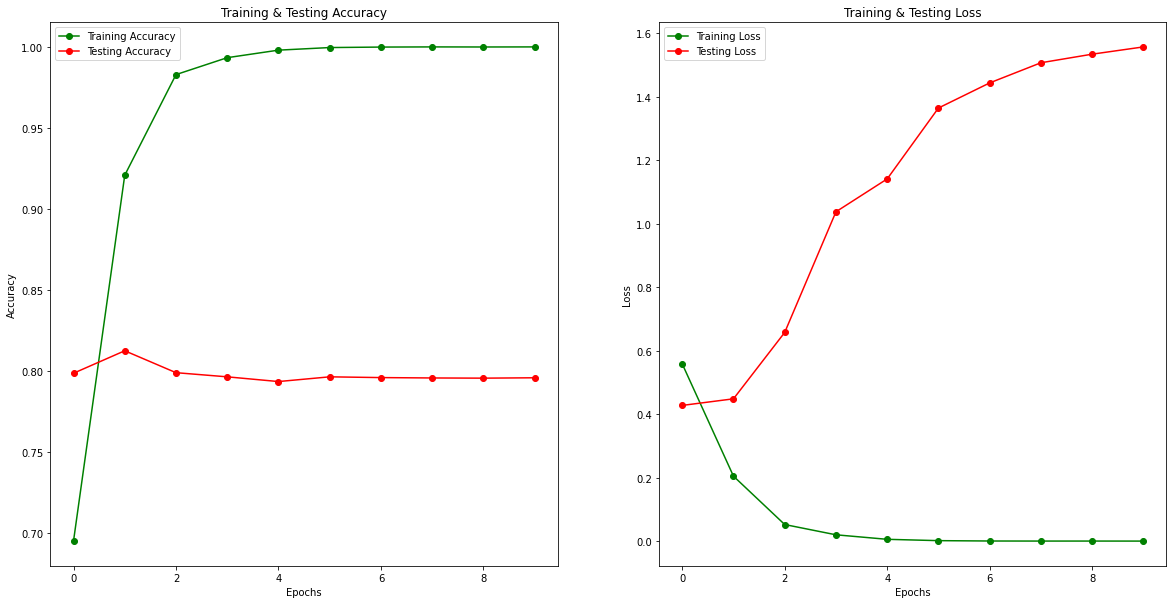

In [23]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.savefig('epochs_w2v_sarcastic.png', dpi=600)

#### Classification report

In [24]:
pred = (model.predict(x_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [25]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.82      0.80      0.81      4560
    Sarcastic       0.78      0.80      0.79      4026

     accuracy                           0.80      8586
    macro avg       0.80      0.80      0.80      8586
 weighted avg       0.80      0.80      0.80      8586



#### Confusion matrix

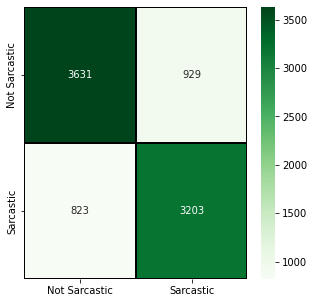

In [26]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])
plt.savefig('confusion_w2v_sarcastic.png', dpi=600)

## GloVe

In [49]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [50]:
max_features = 35000
maxlen = 200

Tokenizing, padding/truncating, word mapping is kept

In [51]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [52]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [53]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
#EMBEDDING_FILE = 'glove.42B.300d.txt'

In [54]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [55]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


#### Model parameters

In [56]:
batch_size = 256
epochs = 10
embed_size = 200
input_length = 200

In [57]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Training GloVe

In [58]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length= input_length, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          5165000   
                                                                 
 lstm_4 (LSTM)               (None, 200, 128)          168448    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,384,969
Trainable params: 219,969
Non-trainable params: 5,165,000
_________________________________________________________________


In [60]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs, callbacks = [learning_rate_reduction])

Epoch 1/10
79/79 [==============================] - 122s 1s/step - loss: 0.5620 - accuracy: 0.7110 - val_loss: 0.4540 - val_accuracy: 0.7877 - lr: 0.0100
Epoch 2/10
79/79 [==============================] - 114s 1s/step - loss: 0.4426 - accuracy: 0.7945 - val_loss: 0.4023 - val_accuracy: 0.8120 - lr: 0.0100
Epoch 3/10
79/79 [==============================] - 114s 1s/step - loss: 0.3663 - accuracy: 0.8353 - val_loss: 0.3815 - val_accuracy: 0.8249 - lr: 0.0100
Epoch 4/10
79/79 [==============================] - 115s 1s/step - loss: 0.3155 - accuracy: 0.8607 - val_loss: 0.3880 - val_accuracy: 0.8248 - lr: 0.0100
Epoch 5/10
79/79 [==============================] - 113s 1s/step - loss: 0.2771 - accuracy: 0.8808 - val_loss: 0.3902 - val_accuracy: 0.8323 - lr: 0.0100
Epoch 6/10
79/79 [==============================] - 114s 1s/step - loss: 0.2416 - accuracy: 0.8970 - val_loss: 0.4168 - val_accuracy: 0.8273 - lr: 0.0100
Epoch 7/10
79/79 [==============================] - ETA: 0s - loss: 0.2157 -

In [61]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 24s 91ms/step - loss: 0.5192 - accuracy: 0.8305
Accuracy of the model on Testing Data is -  83.05380940437317


### Training Analysis

#### Accuracy & Loss

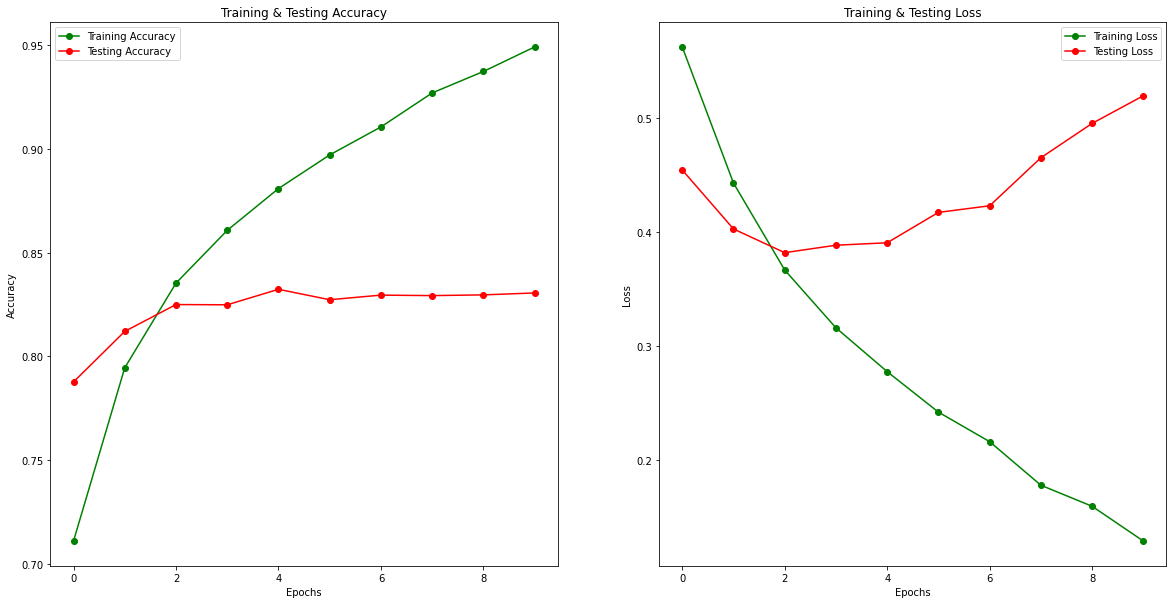

In [62]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.savefig('epochs_glove_sarcastic.png', dpi=600)

#### Classification report

In [63]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]


array([[1],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [64]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.82      0.87      0.85      4560
    Sarcastic       0.85      0.78      0.81      4026

     accuracy                           0.83      8586
    macro avg       0.83      0.83      0.83      8586
 weighted avg       0.83      0.83      0.83      8586



#### Confusion matrix

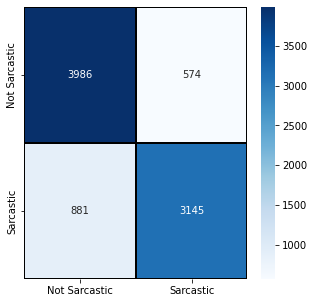

In [65]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])
plt.savefig('confusion_glove_sarcastic.png', dpi=600)

# Fake News Detection

## Loading data

In [66]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

## Data cleaning

In [67]:
true['is_fake'] = 0
false['is_fake'] = 1

In [68]:
df = pd.concat([true,false])

In [69]:
df.isna().sum()

title      0
text       0
subject    0
date       0
is_fake    0
dtype: int64

In [70]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [71]:
df['text']=df['text'].apply(denoise_text)

## Basic EDA

### Data balance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


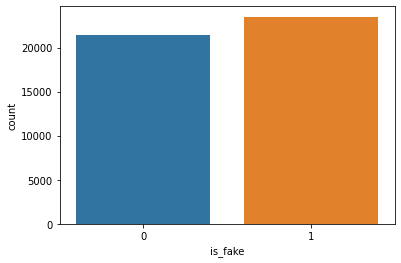

In [72]:
sns.countplot(df.is_fake)
plt.savefig('balance_fakenews.png', dpi=600)

### Wordcloud: real news

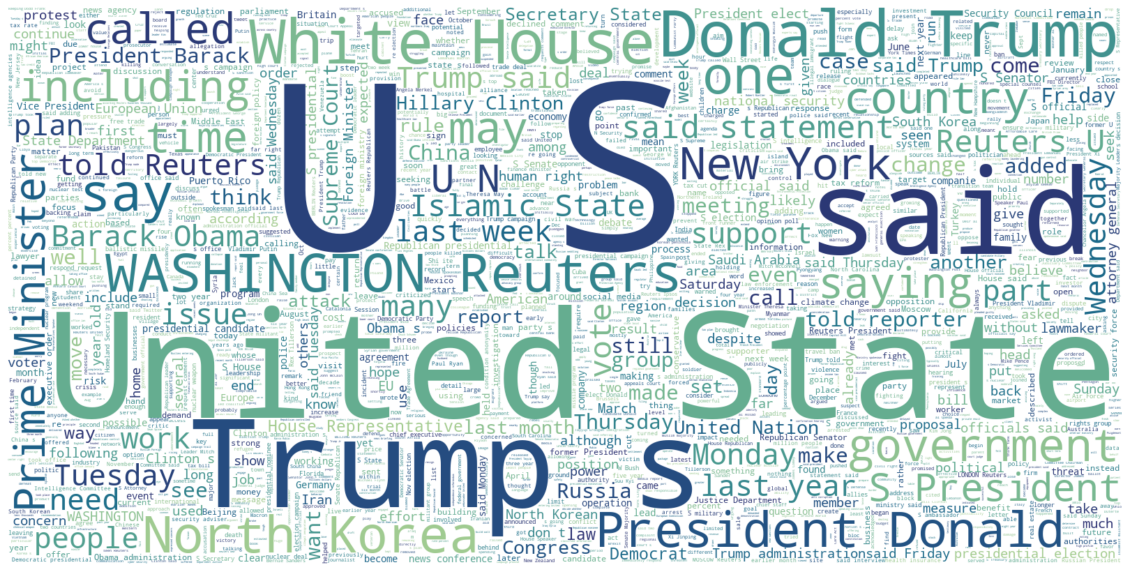

In [73]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white', stopwords = STOPWORDS).generate(" ".join(df[df.is_fake == 0].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_not_fake.png', dpi=600)

### Wordcloud: fake news

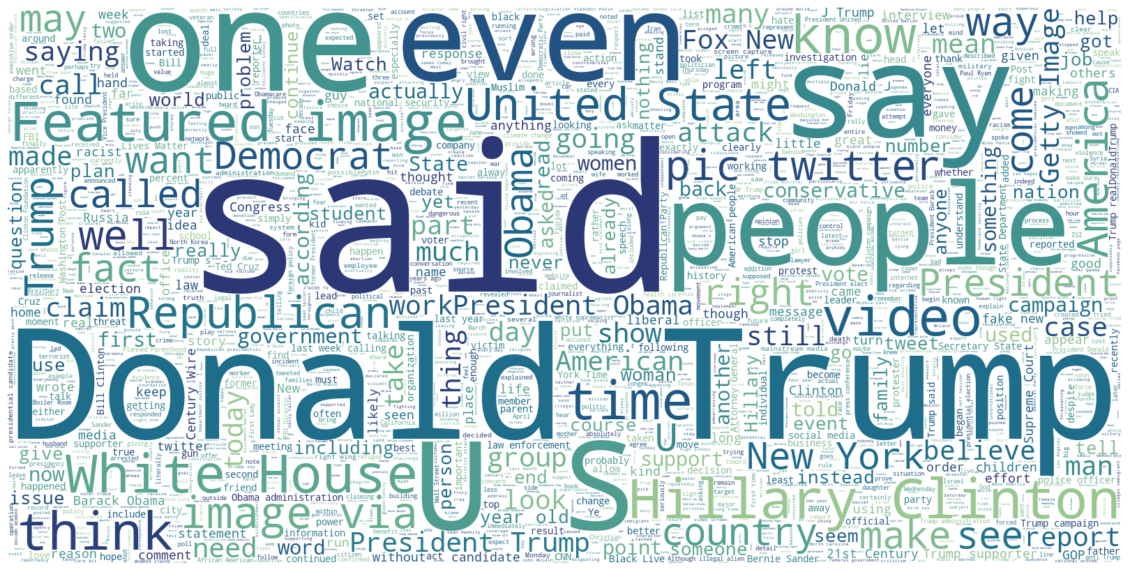

In [74]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white', stopwords = STOPWORDS).generate(" ".join(df[df.is_fake == 1].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_fake.png', dpi=600)

### Number of characters in each text

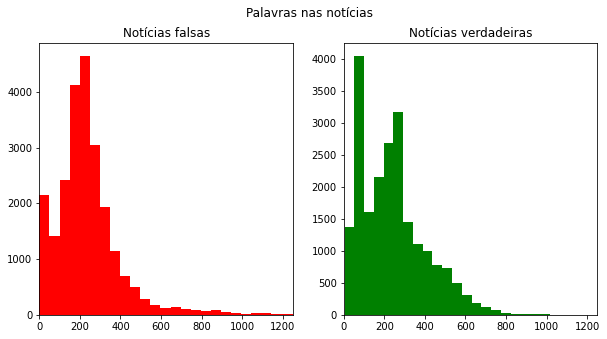

In [75]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_fake']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',bins=100)
ax1.set_title('Notícias falsas')
ax1.set(xlim=(0, 1250))
text_len=df[df['is_fake']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',bins=55)
ax2.set_title('Notícias verdadeiras')
ax2.set(xlim=(0, 1250))
fig.suptitle('Palavras nas notícias')
plt.savefig('wordcount_fakenews.png', dpi=600)

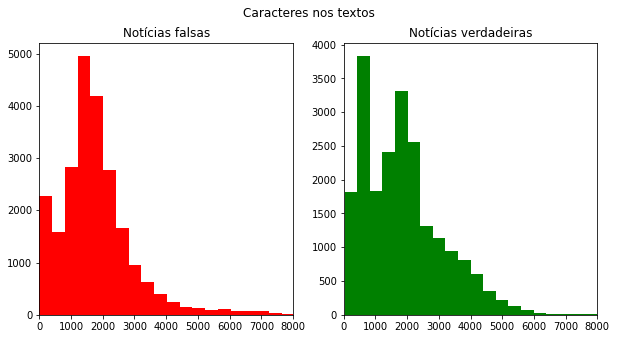

In [76]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_fake']==1]['text'].str.len()
ax1.hist(text_len,color='red', bins=100)
ax1.set_title('Notícias falsas')
ax1.set(xlim=(0, 8000))
text_len=df[df['is_fake']==0]['text'].str.len()
ax2.hist(text_len,color='green',bins=50)
ax2.set_title('Notícias verdadeiras')
ax2.set(xlim=(0, 8000))
fig.suptitle('Caracteres nos textos')
plt.savefig('charcount_fakenews.png', dpi=600)

### Number of words in each text

### Average word length in a text

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


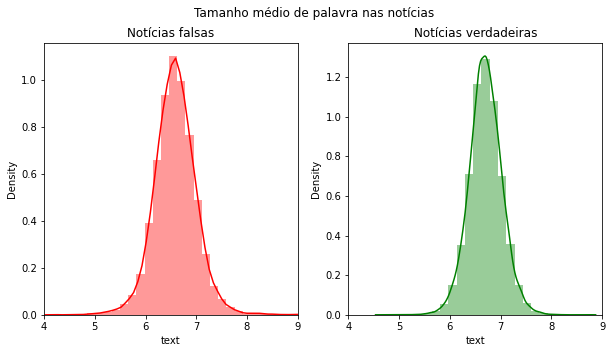

In [77]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_fake']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red',bins=100)
ax1.set_title('Notícias falsas')
ax1.set(xlim=(4, 9))
word=df[df['is_fake']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green',bins=25)
ax2.set_title('Notícias verdadeiras')
ax2.set(xlim=(4, 9))
fig.suptitle('Tamanho médio de palavra nas notícias')
plt.savefig('avgwlength_fakenews.png', dpi=600)

## GloVe

In [78]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.is_fake, test_size = 0.3 , random_state = 0)

In [79]:
max_features = 10000
maxlen = 300

Tokenizing, padding/truncating, word mapping is kept

In [80]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [81]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [82]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
#EMBEDDING_FILE = 'glove.42B.300d.txt'

In [83]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [84]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


#### Model parameters

In [85]:
batch_size = 256
epochs = 10
embed_size = 200
input_length = 300

In [86]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Training GloVe

In [87]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length= input_length, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 200)          2000000   
                                                                 
 lstm_6 (LSTM)               (None, 300, 128)          168448    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,219,969
Trainable params: 219,969
Non-trainable params: 2,000,000
_________________________________________________________________


In [89]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs, callbacks = [learning_rate_reduction])

Epoch 1/10
123/123 [==============================] - 271s 2s/step - loss: 0.1378 - accuracy: 0.9450 - val_loss: 0.0274 - val_accuracy: 0.9919 - lr: 0.0100
Epoch 2/10
123/123 [==============================] - 268s 2s/step - loss: 0.0351 - accuracy: 0.9883 - val_loss: 0.0288 - val_accuracy: 0.9895 - lr: 0.0100
Epoch 3/10
123/123 [==============================] - 267s 2s/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.0133 - val_accuracy: 0.9967 - lr: 0.0100
Epoch 4/10
123/123 [==============================] - 265s 2s/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.0147 - val_accuracy: 0.9963 - lr: 0.0100
Epoch 5/10
123/123 [==============================] - 264s 2s/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.0116 - val_accuracy: 0.9975 - lr: 0.0100
Epoch 6/10
123/123 [==============================] - 268s 2s/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0091 - val_accuracy: 0.9976 - lr: 0.0100
Epoch 7/10
123/123 [==============================] - 267s 2s/st

In [90]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

421/421 [==============================] - 56s 132ms/step - loss: 0.0069 - accuracy: 0.9979
Accuracy of the model on Testing Data is -  99.79212880134583


### Training Analysis

#### Accuracy & Loss

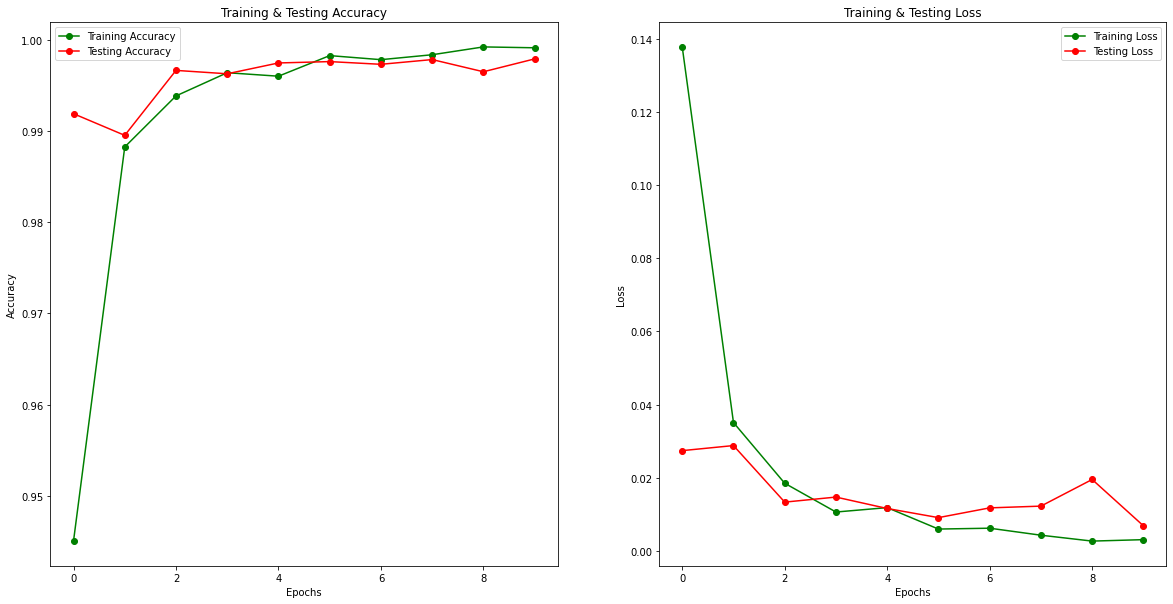

In [91]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.savefig('epochs_fakenews.png', dpi=600)

#### Classification report

In [92]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]


array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [93]:
print(classification_report(y_test, pred, target_names = ['Real','Fake']))

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      6401
        Fake       1.00      1.00      1.00      7069

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



#### Confusion matrix

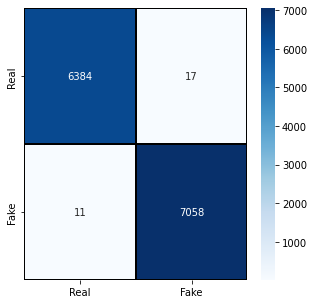

In [94]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Real','Fake'] , columns = ['Real','Fake'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Real','Fake'] , yticklabels = ['Real','Fake'])
plt.savefig('confusion_glove_fakenews.png', dpi=600)